# 1. Feedforward neural network

We're exploring a feedforward neural network with multiple interconnected artificial neurons. In this initial section, you'll implement the feedforward pass (representing the propagation of neural activity through the network) for a basic task. In future notebooks, you'll learn how to train this network to improve its
 accuracy.



## 1.1 Intro

In this task, we aim to simulate the activity of a simplified feedforward neuronal network that processes input signals (stimuli/features) and maps them to the desired outputs (behavioral responses/targets). These inputs, $\mathbf{x}$, can be thought of as a stimulus pattern received by the sensory neurons, while the outputs, $\mathbf{y}$, represent the downstream target, akin to correct motor or cognitive outputs.

Here we are presented with a training dataset $\mathbf{D}$, which gives $N$ examples of correct outputs for several different input stimuli ($(\mathbf{x}_i, y_i)_{i=1}^N$).

We train a neural network with a single hidden layer to perform logical computations akin to simple neural circuits that process binary signals (like spikes). These logic gates (AND, OR, XOR, XNOR) can be thought of as simplified forms of decision-making processes in the brain. Neurons act as nonlinear integrators of incoming signals, which allows them to compute functions similar to logical gates.

In our model, the input pairs \(A\) and \(B\) represent binary signals (spikes or no spikes), and the network processes these inputs through interconnected layers to produce an output signal, $\mathbf{y}$, analogous to the firing of a downstream neuron.

The following table shows the neural network's output for different combinations of inputs \(A\) and \(B\), with each output corresponding to a different logical gate. Each row corresponds to one example with binary inputs \(A\) and \(B\) and the correct binary outputs (AND, OR, XOR, XNOR):


\begin{array}{|c|c|c|c|c|c|}
\hline
A & B & AND & OR & XOR & XNOR \\
\hline
0 & 0 & 0 & 0 & 0 & 1 \\
0 & 1 & 0 & 1 & 1 & 0 \\
1 & 0 & 0 & 1 & 1 & 0 \\
1 & 1 & 1 & 1 & 0 & 1 \\
\hline
\end{array}


In this way, the neural network, with its simple architecture, replicates fundamental decision-making or signal-processing operations akin to neural circuits.


##1.2 Importing libraries

First, let's import the required libraries. Instead of relying on specialized machine learning libraries like pytorch, we'll handle array operations ourselves with numpy. For visualization, we'll utilize matplotlib.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 1.3 Preparing the Data Sets
It's time to organize our data. Given that we have just four unique input combinations (as detailed in the previous table), our task is fairly straightforward. We'll capture the dataset in the form of a list containing possible $(\mathbf{u}, v)$ pairs, using the terminology mentioned earlier. The data for the AND operation has already been provided. Your initial challenge is to define the datasets for the OR, XOR, and XNOR operations.

In [3]:
#the dataset defined by the logical operator AND
dataset_and = [
                ([0, 0], 0),
                ([0, 1], 0),
                ([1, 0], 0),
                ([1, 1], 1)
                ]

#the dataset defined by the logical operator OR
dataset_or = [
                ([0, 0], 0),
                ([0, 1], 1),
                ([1, 0], 1),
                ([1, 1], 1)
                ]

#the dataset defined by the logical operator XOR
dataset_xor = [
                ([0, 0], 0),
                ([0, 1], 1),
                ([1, 0], 1),
                ([1, 1], 0)
                ]
#the dataset defined by the logical operator XNOR
dataset_xnor = [
                ([0, 0], 1),
                ([0, 1], 0),
                ([1, 0], 0),
                ([1, 1], 1)
                ]

Batch processing can speed up the learning process. This is because, instead of looping through data points one by one, we can process entire arrays of data simultaneously.


Here we introduce a 'generate_batch' function. This method will:

- Accept a user-defined dataset and batch size as inputs.
- Produce a batch of the specified size with appropriate examples from the dataset.

In [4]:
# Batch Creation: Using a dataset D and a specified batch_size N, this function
# selects N random samples from D. It returns a tuple containing ordered arrays:
# (inputs, targets). For each entry, targets[i] matches the target for inputs[i].

def generate_batch(dataset, batch_size):
    #differentiate inputs (features) from targets and transform each into
    #numpy array with each row as an example
    inputs = np.vstack([ex[0] for ex in dataset])
    targets = np.vstack([ex[1] for ex in dataset])

    #randomly choose batch_size many examples; note there will be
    #duplicate entries when batch_size > len(dataset)
    rand_inds = np.random.randint(0, len(dataset), batch_size)
    inputs_batch = inputs[rand_inds]
    targets_batch = targets[rand_inds]

    return inputs_batch, targets_batch


We can now generate batches for any of the datasets defined above. As an example, to obtain 100 examples out of the XOR dataset, we just run

In [7]:
inputs_xor, targets_xor = generate_batch(dataset_xor, batch_size=100)

## 1.4 Network Initialization

Let's build our single hidden layer neural network from scratch in python, but in the style of [Pytorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html).

We'll define a class, *nn_one_layer*, which will be initialized with the following hyperparameters:


*   input_size:  the dimensionality of the input stimuli.
*   hidden_size: the hidden layer's dimensionality, the number of hidden units or "neurons."
*   target_size: the output size.

The hyperparameters also guide the dimensions of the network's weight matrices. Here we have two weight matrices, the input weights $W_{a←x}$ and the output weights $W_{y←a}$. When provided with the input stimuli as a vector, $\mathbf{x}$, the network produces the output, $\hat{y}$, via:

\begin{align}
\mathbf{a} &= f(\mathbf{x}W_{a←x}) \\
\hat{y} &= \mathbf{a}W_{y←a}
\end{align}

Where $\mathbf{a}$ is the 'hidden layer activity' of the network and $f$ is the _activation function_, which determines how the (synaptic) inputs to a neuron are converted into an output (e.g. firing rate). This is usually a non-linear function, and here we will take $f$ to be the sigmoid function, $f(z) =\frac{1}{1+e^{-z}}$. As the output dimension is 1 for this task, we can just use a scalar for the network output $y$.



### 2.4.1 Matrix Representation of Equations

To allow for batch processing, let's switch to matrix notation.

Let $b_s$ denote the batch size, and $i_s$, $h_s$ and $o_s$ the input, hidden and output size respectively. Now we can write the dimension of the input matrix $\mathbf{X}$ as $(b_s, i_s)$. The equations for the 'batch hidden activity' $\mathbf{H}$ and 'batch output' $\mathbf{y}$ is just the same as before

\begin{align}
\mathbf{Z} &= \mathbf{X}W_{a←x} \\
\mathbf{A} &= f(\mathbf{Z}) \\
\hat{\mathbf{y}} &= \mathbf{A}W_{y←a}
\end{align}

Understanding Check: Can you determine the dimensions of $\mathbf{A}$ and $\hat{\mathbf{y}}$ based on $i_s$, $h_s$, $o_s$, and $b_s$? How about the dimensions of $W_{a←x}$ and $W_{y←a}$?

Fill in the 'TODO's below to build one layer of the neural network.

In [18]:
#code for *nn_one_layer* which initiliases the model and also defines the forward
#computation. we will initialise each weight randomly according to a normal
#distribution of standard deviation sigma = 0.1.

def sigmoid(a):
  # define the sigmoid function (act)
    f_sigmoid = 1/(1+np.e**(-a))
    return f_sigmoid

def relu(a):
    # relu function
    f_relu = a * (a>0)
    return f_relu


class nn_one_layer():
    def __init__(self, input_size, hidden_size, output_size):
        #define the input/output weights Wax, Wya, with standard deviation sigma = 0.1.
        self.Wax = 0.1 * np.random.randn(input_size, hidden_size)
        self.Wya = 0.1 * np.random.randn(hidden_size, output_size)

        self.f = sigmoid

    def forward(self, x):
      # hint: use np.matmul to perform matrix multiplication
      # hint 2: remember to write 'self' where used in definitions above
        z = x @ self.Wax
        a = self.f(z)
        y = a @ self.Wya
        return y, a, z

You should now be able to initialise your model and check it can perform a batch computation on the datasets defined above.

### 2.4.2 histogram of output values
Fill in the 'TODO's below to view a scatter plot and a histogram of output values for the XOR dataset as predicted by an untrained neural network of 5 hidden neurons.

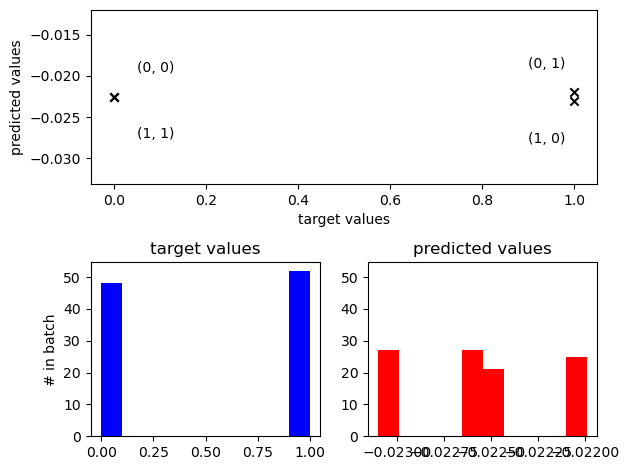

In [ ]:
input_size = 2
hidden_size = 5
output_size = 1

nn = nn_one_layer(input_size, hidden_size, output_size) #initialise model
preds_xor, _, _ = nn.forward(inputs_xor) #prediction made by model on batch xor input

_, inds = np.unique(inputs_xor, return_index=True, axis=0)


# plot target vs predictions along with a histogram of each
fig = plt.figure()
ax1 = plt.subplot2grid((2,2), (0,0), rowspan=1, colspan=2)
plt.scatter(targets_xor[inds], preds_xor[inds], marker='x', c='black')
for i in inds:
    coord = '({}, {})'.format(inputs_xor[i][0], inputs_xor[i][1])
    xoffset = 0.05 if targets_xor[i] == 0 else -0.1
    yoffset = 0.003 if preds_xor[i] > np.mean(preds_xor[inds]) else -0.005
    plt.text(targets_xor[i] + xoffset, preds_xor[i] + yoffset, coord)
plt.xlabel('target values')
plt.ylabel('predicted values')
plt.ylim([np.min(preds_xor) - 0.01, np.max(preds_xor) + 0.01])
ax2 = plt.subplot2grid((2,2), (1,0), rowspan=1, colspan=1)
plt.hist(targets_xor, color='blue')
ax2.set_title('target values')
plt.ylabel('# in batch')
ax3 = plt.subplot2grid((2,2), (1,1), rowspan=1, colspan=1, sharey=ax2)
plt.hist(preds_xor, color='red')
ax3.set_title('predicted values')

fig.tight_layout()


If you managed to generate the plot, hopefully you see that the network is pretty useless at the moment! It doesn't get near the required target values according to the true XOR operator, let alone understanding that it should only produce logical output vaues of 0 or 1.

The expectation is that, with a good learning procedure to train the weights $W_1$ and $W_2$, we should be able to produce a network which better captures XOR, or indeed any other logical gate we fancy.



## 2.5 Exploration & Experimentation time

It's exploration time! Modify the parameters and see how it impacts the predictions. Also try generating AND, OR and XNOR datasets and plotting the histograms of output values.

# 3. Introduction to RNN Dynamics

The objective of this section is to understand the forward pass of a recurrent neural network, which roughly corresponds to the dynamics of neural activity in a recurrently connected part of the brain, such as the prefrontal cortex.



## 3.1 Introduction to RNN Dynamics:

RNNs are a type of neural network with loops, allowing information persistence. Unlike traditional feedforward neural networks, RNNs share parameters across different steps in this sequence. Here we will implement a type of RNN called a 'leaky RNN', which produces reasonably brain-like dynamics:

$$
\tau\frac{d a_{i}(t)}{d t} = -a_{i}(t) + f(\sum_{j=1}^{N} w_{i j} a_{j}(t) + x_{i}(t)).
$$

Here's a breakdown of each term:

- $\frac{d a_{i}(t)}{d t}$: Represents the how much the firing rate $a$ of a neuron $i$ changes over a short step in time $dt$.

- $a_{i}(t)$: the firing rate of neuron $i$ at time $t$. The term $-a_{i}(t)$ means that, without any new synaptic inputs, the firing rate would decay exponentially towards zero.

- $w_{i j}$: This represents the weight from neuron $j$ to neuron $i$ within the recurrent layer:. It dictates how much of neuron $j$'s state should influence neuron $i$. (in the slides this is represented by the matrix $W_{a→a}$)

- $f()$: the activation (input-output) function

- $\sum_{j=1}^{N}$: This is a summation over all neurons in the network, indicating that the next state of neuron $i$ is influenced by all neurons, including itself.

- $x_{i}(t)$: Represents any stimulus input (from the input neurons) to neuron $i$ at time $t$.

Here we assume that the input weight matrix (connecting input stimuli to the recurrently-connected neurons) is the identity matrix, and can thus be ignored.

The discrete time version (obtained using the Euler discretisation), which we use to code the model, is similar:

$$
a_{i}(t) = a_{i}(t-1) + \frac{Δt}{τ} \left(-a_{i}(t-1) + f(\sum_{j=1}^{N} w_{i j} a_{j}(t-1) + x_{i}(t-1)\right).
$$


The equation as a whole gives a sense of "memory" to the network, where the future state of a neuron is determined by its current state, the states of all other neurons, and any external input.

## 3.2 Understanding Activation Functions

Activation functions introduce non-linearity into neural networks, allowing neural networks to tackle more complex problems.

Let's visualize some common activation functions:

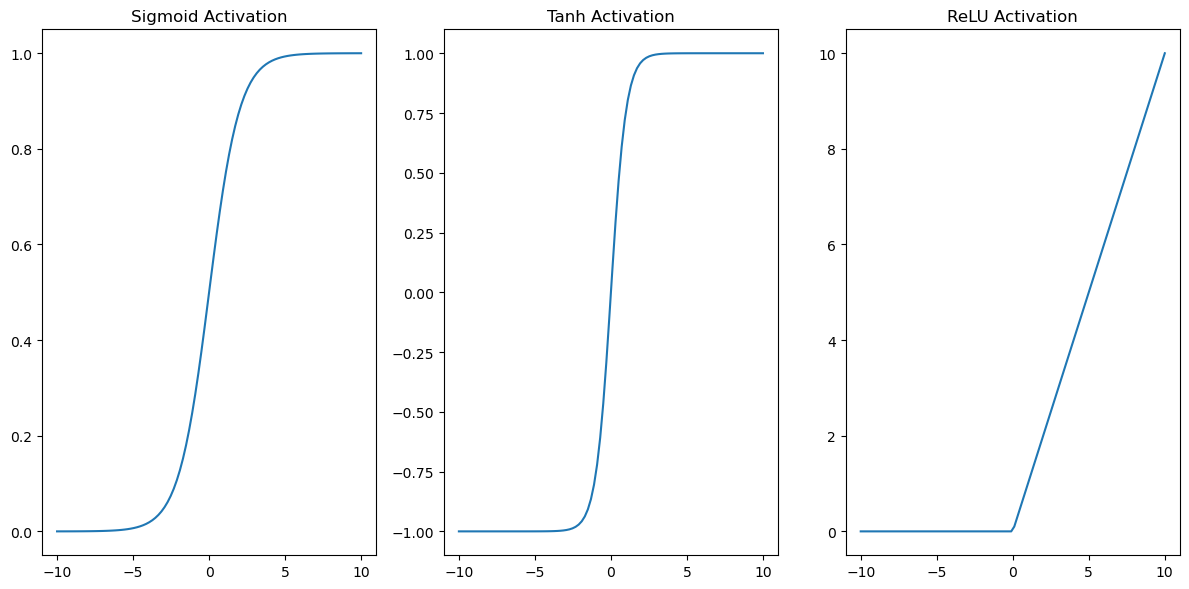

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define common activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# hint, np.tanh and np.maximum could come in handy
def tanh(x):
    return np.tanh(x)

def relu(x):
    return x * (x > 0)

# Plotting
x = np.linspace(-10, 10, 100)
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(x, sigmoid(x))
plt.title("Sigmoid Activation")

plt.subplot(1, 3, 2)
plt.plot(x, tanh(x))
plt.title("Tanh Activation")

plt.subplot(1, 3, 3)
plt.plot(x, relu(x))
plt.title("ReLU Activation")

plt.tight_layout()
plt.show()

## 3.3 Forward Pass (neural dynamics) Demonstration


We'll now demonstrate how an RNN processes a sequence of input spikes and produces a dynamic activity pattern.

In [74]:
N = 3  # number of neurons
sequence = [0, 1, 0, 1]
dt = 1
tau = 1

# Random initializations
W = np.random.randn(N, N)
a = np.random.randn(N)

states = [a]

# Forward pass through the sequence
for x_t in sequence:
    da = -a + tanh((W@a) + x_t) # Using the RNN dynamics equation, and the tanh activation function
    a = a + (dt/tau)*da
    states.append(a)

print("Firing rates over time for the provided sequence:", states)


Firing rates over time for the provided sequence: [array([-2.19141249,  0.14716513,  0.8921817 ]), array([ 0.99549715, -0.87207601,  0.11326195]), array([0.86479993, 0.99028674, 0.58381365]), array([-0.05699558,  0.29726879, -0.81424247]), array([-0.71083252,  0.11977548,  0.93445492])]


## 3.4 Sequence Generation with Initialized RNN

An RNN with random weights and an initial state can generate a sequence without any external input. Here, we'll set our external input
$h_{i}(t)$ to zero and observe the sequence generation based solely on the RNN's initial state and dynamics. Let's observe this behavior:

In [ ]:
np.random.seed(500)

def forward_pass(W, x, initial_state, num_steps=100):

    a = initial_state
    x = np.zeros(N)  # External input is zero
    dt = 1
    tau = 1

    states = [a]


    for _ in range(num_steps):
        da = -0.1*a + tanh((W@a))
        a = a + (dt/tau)*da
        states.append(a)

    return states

initial_state = np.random.randn(N)
generated_sequence = forward_pass(W, x, initial_state)
print("Generated sequence:", generated_sequence)


Generated sequence: [array([-0.37736358,  0.16675892,  0.68280238]), array([0.56871801, 0.1756858 , 0.15790123]), array([ 0.36899153,  0.57504731, -0.26541455]), array([-0.50526185,  0.1682237 , -0.29487468]), array([-0.8703846 , -0.50097923,  0.15489157]), array([ 0.05731514, -0.64870969,  0.48248951]), array([0.95062807, 0.15222635, 0.13443822]), array([ 0.47417347,  0.78386711, -0.39624683]), array([-0.50952983,  0.20799917, -0.38924624]), array([-1.04145271, -0.52117888,  0.13200307]), array([-0.07741974, -0.80027088,  0.54704888]), array([0.87689629, 0.04237241, 0.22566966]), array([ 0.70559373,  0.73729315, -0.33191717]), array([-0.29717607,  0.40447597, -0.47772867]), array([-1.07768632, -0.36844449,  0.00597811]), array([-0.23694834, -0.86436156,  0.50721184]), array([ 0.73930783, -0.06474339,  0.30519114]), array([ 0.90610447,  0.65646799, -0.25082412]), array([-0.10048363,  0.6213569 , -0.53786562]), array([-1.00186205, -0.20006514, -0.11725705]), array([-0.43599339, -0.82136

## 3.5 Visualizing Generated Sequences



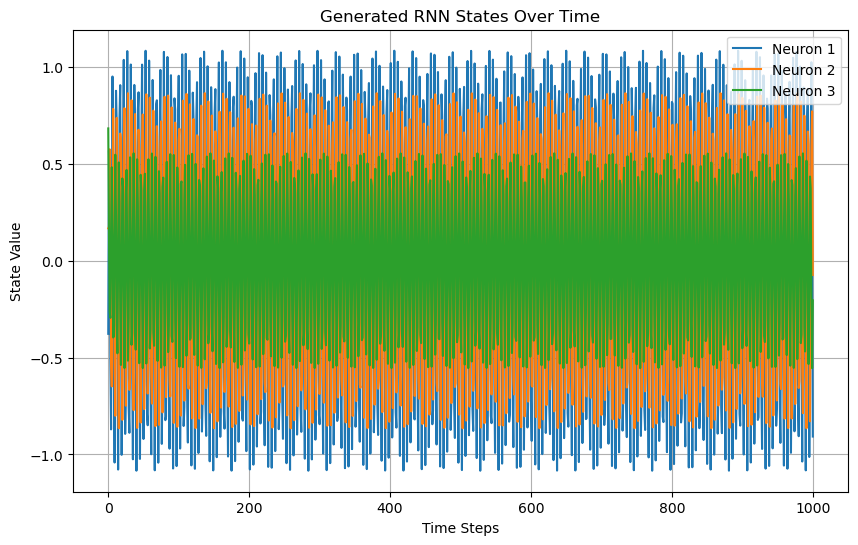

In [93]:
# Visualizing the generated sequence
plt.figure(figsize=(10, 6))

# If you're working with multi-dimensional states, you can plot each dimension separately
for i in range(N):
    plt.plot([state[i] for state in generated_sequence], label=f"Neuron {i+1}")

plt.title("Generated RNN States Over Time")
plt.xlabel("Time Steps")
plt.ylabel("State Value")
plt.legend()
plt.grid(True)
plt.show()


From the plot, observe how the firing rates of the different neurons evolve over time.

## 3.6 Exploration & Experimentation time

It's exploration time! Modify the RNN parameters and see how it impacts the sequence generation. Change the weights, initial states, or even the activation function.

Now you have coded up the forward pass of a simple feedforward neural network, and a  simple recurrent neural network, which corresponds roughly to the dynamic neural activity in the brain. Unfortunately, your networks aren't great at solving tasks yet. For that, they need to learn (up next time).